# Build and Deploy the Best Model
This notebook sets up and uses the Blob Storage that was setup in the Setup Notebook.

In [3]:
# Check core SDK version number..
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.2.0


In [4]:
from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.data.data_reference import DataReference
from azureml.data.datapath import DataPath
from azureml import telemetry

from msrest.exceptions import HttpOperationError
from IPython.display import display, HTML
import json, os
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Initialize an existing Workspace

Set the names of your experiement and model below

In [5]:
experiment_name = "automl-payment-default-classify"

Initialize the existing Workspace with CLI Authentication

In [6]:
from azureml.core.authentication import AzureCliAuthentication
from azureml.core.workspace import Workspace

cli_auth = AzureCliAuthentication()
ws = Workspace.from_config(auth=cli_auth)
ws.get_details()

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.2.0
Subscription ID,b9f1c816-0637-419c-b0f6-a8392690c7aa
Workspace,paydmlws91
Resource Group,paydmlrg91
Location,westeurope
Experiment Name,automl-payment-default-classify


#### If you want to use a Service Principle to authenticate, use the below

In [5]:
'''
from azureml.core.authentication import ServicePrincipalAuthentication

tenant_id                  = "88888888-8888-8888-8888-888888888888"
subscription_id            = "88888888-8888-8888-8888-888888888888"
service_principal_id       = "88888888-8888-8888-8888-888888888888"
service_principal_password = "88888888-8888-8888-8888-888888888888"
workspace_name="myaiwork"

sp = ServicePrincipalAuthentication(tenant_id=tenant_id,
                                    service_principal_id=service_principal_id,
                                    service_principal_password=service_principal_password)
ws = Workspace.from_config(auth=sp)

experiment=Experiment(ws, experiment_name)
output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

'''

'\nfrom azureml.core.authentication import ServicePrincipalAuthentication\n\ntenant_id                  = "88888888-8888-8888-8888-888888888888"\nsubscription_id            = "88888888-8888-8888-8888-888888888888"\nservice_principal_id       = "88888888-8888-8888-8888-888888888888"\nservice_principal_password = "88888888-8888-8888-8888-888888888888"\nworkspace_name="myaiwork"\n\nsp = ServicePrincipalAuthentication(tenant_id=tenant_id,\n                                    service_principal_id=service_principal_id,\n                                    service_principal_password=service_principal_password)\nws = Workspace.from_config(auth=sp)\n\nexperiment=Experiment(ws, experiment_name)\noutput = {}\noutput[\'SDK version\'] = azureml.core.VERSION\noutput[\'Subscription ID\'] = ws.subscription_id\noutput[\'Workspace\'] = ws.name\noutput[\'Resource Group\'] = ws.resource_group\noutput[\'Location\'] = ws.location\noutput[\'Experiment Name\'] = experiment.name\npd.set_option(\'display.max_co

# Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

#### Creation of AmlCompute takes approximately 5 minutes.
If the AmlCompute with that name is already in your workspace this code will skip the creation process. As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [7]:
# Choose a name for your AmlCompute cluster.
amlcompute_cluster_name = "StandardCluster"
AML_MIN_NODES = 0
AML_MAX_NODES = 5

# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].name == amlcompute_cluster_name :
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
else :
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_DS3_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                min_nodes = AML_MIN_NODES,
                                                                max_nodes = AML_MAX_NODES)
    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
s = compute_target.serialize()

# get a view of current AmlCompute status
output = {}
output['Cluster Name'] = s['name']
output['VM Size'] = s['properties']['properties']['vmSize']
output['VM Priority'] = s['properties']['properties']['vmPriority']
output['VM Size'] = s['properties']['properties']['vmSize']
output['Min Nodes'] = s['properties']['properties']['scaleSettings']['minNodeCount']
output['Max Nodes'] = s['properties']['properties']['scaleSettings']['maxNodeCount']
output['Current Nodes'] = s['properties']['status']['currentNodeCount']
output['Auto Scale Down Time'] = s['properties']['properties']['scaleSettings']['nodeIdleTimeBeforeScaleDown']
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


,
Cluster Name,StandardCluster
VM Size,STANDARD_DS3_V2
VM Priority,Dedicated
Min Nodes,0
Max Nodes,5
Current Nodes,0
Auto Scale Down Time,PT120S


# Connect to Data

### Retrieve dataset details from the KeyVault
This is just to showcase how to pass and retrieve things from the keyvault.

In [8]:
keyvault = ws.get_default_keyvault()

dataset_name = keyvault.get_secret(name="DATASETNAME")

print(f"Retrieved : {dataset_name}")

Retrieved : payment_data


### Load the Data
We can load the payments dataset from csv files in a referenced blob storage account... called a Dataset. The data contains both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model - in this case the 'default_payment' column. Next, we'll split the data using random_split and extract the training data for the model.

Note: If you ran the preperation Notebook, it should find the Dataset that was registered with that Notebook. Next, we can read and process the data 

In [9]:
from azureml.core import Dataset

# Retrieve the file(s) from a previously registered dataset
dataset = Dataset.get_by_name(ws, dataset_name, version='latest')

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,1,20000.00,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0.00,0,0,1
1,2,120000.00,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000.00,0,2000,1
2,3,90000.00,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000.00,1000,5000,0


#### Prepare the Data
Sometimes we need to minipulate the date before submitting it for training. Especially if there are features you decide not to take into the training process. In this case we drop a column from the dataset that is not needed. Ideally you should be using Azure Data Factory to process and prep the data.

In [10]:
dataset = dataset.drop_columns(columns=["ID"])
dataset.take(3).to_pandas_dataframe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,20000.00,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0.00,0,0,1
1,120000.00,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000.00,0,2000,1
2,90000.00,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000.00,1000,5000,0


# Explore Data
We can use Pandas to explore the data further using the to_pandas_dataframe() Dataset method. For more info on Datasets see https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.dataset(class)

In [11]:
df=dataset.to_pandas_dataframe()
print(f"Data Shape: {df.shape}")
df.describe()

Data Shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,29995.00,29992.00,29995.00,29984.00,29982.00,29991.00,30000.00,29981.00,29988.00,30000.00
mean,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,...,43243.49,40272.14,38861.57,5606.57,5851.34,5197.24,4826.08,4729.05,5167.57,0.22
std,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,...,64312.26,60733.36,59553.84,16344.53,22833.53,17532.88,15666.16,14975.07,17597.45,0.42
min,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,...,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,2323.00,1761.75,1256.00,1000.00,832.00,390.00,296.00,250.00,116.00,0.00
50%,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,...,19048.00,18097.00,17067.00,2100.00,2008.00,1800.00,1500.00,1500.00,1500.00,0.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,...,54470.00,50149.75,49146.50,5006.00,5000.00,4500.00,4013.25,4021.00,4000.00,0.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,...,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00


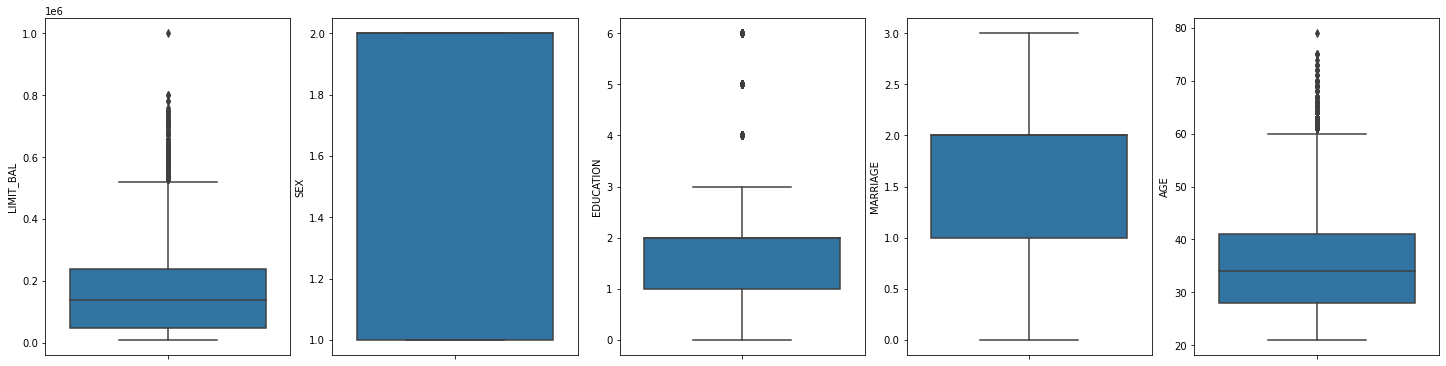

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df1 = df[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 5))
index = 0
axs = axs.flatten()
for k,v in df1.items():
    sns.boxplot(y=k, data=df1, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [13]:
import numpy as np

# Look for outliers 
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))
        

Column LIMIT_BAL outliers = 0.56%
Column SEX outliers = 0.00%
Column EDUCATION outliers = 1.51%
Column MARRIAGE outliers = 0.00%
Column AGE outliers = 0.91%
Column PAY_0 outliers = 10.43%
Column PAY_2 outliers = 14.70%
Column PAY_3 outliers = 14.03%
Column PAY_4 outliers = 11.69%
Column PAY_5 outliers = 9.89%
Column PAY_6 outliers = 10.26%
Column BILL_AMT1 outliers = 8.00%
Column BILL_AMT2 outliers = 7.98%
Column BILL_AMT3 outliers = 8.23%
Column BILL_AMT4 outliers = 8.74%
Column BILL_AMT5 outliers = 9.08%
Column BILL_AMT6 outliers = 8.99%
Column PAY_AMT1 outliers = 9.10%
Column PAY_AMT2 outliers = 8.99%
Column PAY_AMT3 outliers = 8.64%
Column PAY_AMT4 outliers = 9.98%
Column PAY_AMT5 outliers = 9.76%
Column PAY_AMT6 outliers = 9.82%
Column default_payment outliers = 100.00%


In [ ]:
# Let's see how the distributions are like
fig, axs = plt.subplots(ncols=6, nrows=4, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    x=axs[index]
    sns.distplot(v, ax=x)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Take a closer look at age
sns.distplot(df[['AGE']], bins=[10,20,30,40,50,60,70,80,90,100])

In [ ]:
# analyise the impact of AGE, LAST PAYMENT and LAST BILL on defaulted payments
sns.pairplot(df[['AGE', 'PAY_AMT1', 'BILL_AMT1','default_payment']], hue='default_payment')

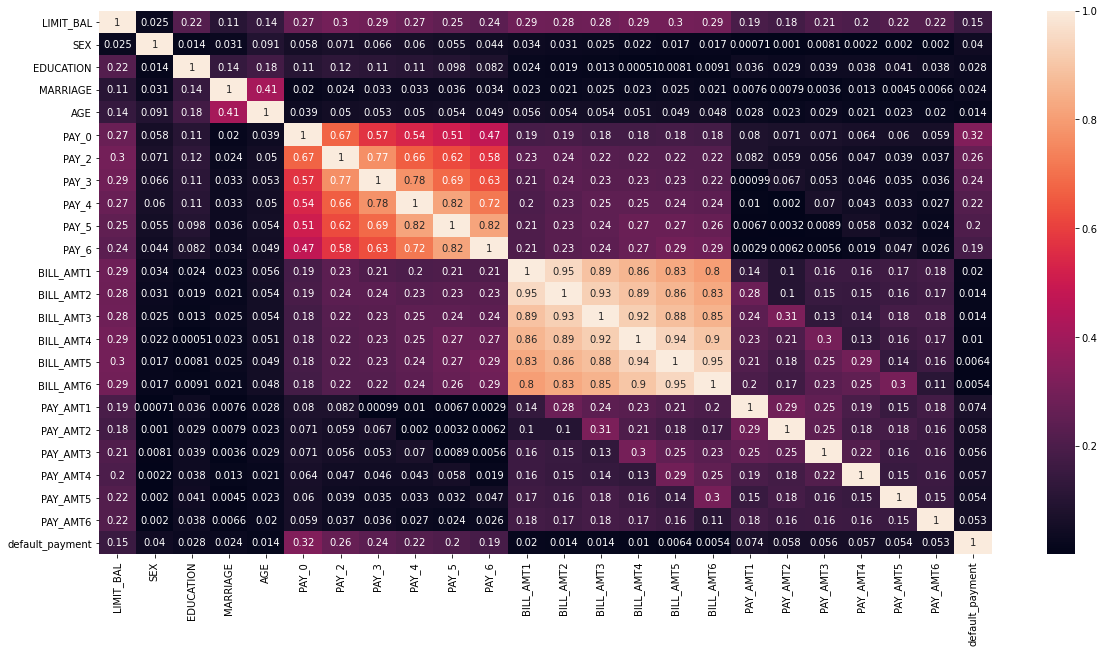

In [17]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

In [ ]:
from sklearn import preprocessing

# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
               'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6' ]
x = df.loc[:,column_sels]
y = df['default_payment']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20, 12))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


# Train
### Split Validation Data and Training Data. 
We use the Validation Data to do our own validation later.


In [12]:
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = 'default_payment'
training_data.take(3).to_pandas_dataframe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,20000.00,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0.00,0,0,1
1,120000.00,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000.00,0,2000,1
2,90000.00,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000.00,1000,5000,0


### Initialise AutoMLConfig object
This defines the settings and data used to run the experiment.

For more information check https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [12]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'accuracy',
    "enable_early_stopping": True,
    "max_concurrent_iterations": AML_MAX_NODES, # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_hours": 2,              # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

### Submit Experiment
Call the submit method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.

#### If you need to retrieve a run that already started (without running the experiment again), use the following code


In [13]:
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment = experiment, run_id = 'AutoML_c50723a2-10c8-4056-b1a6-f67989d103f4')
#remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-payment-default-classify,AutoML_c50723a2-10c8-4056-b1a6-f67989d103f4,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


**Submit the Experiment run**

In [22]:
# Submit the Experiment
remote_run = experiment.submit(automl_config, show_output = False)

### Monitor Experiment
We can more the experiment run in the notebook with teh RunDetails widget without having to check the GUI

In [26]:
# Check the progress of the run - summary data and link to AML Studio
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-payment-default-classify,AutoML_c50723a2-10c8-4056-b1a6-f67989d103f4,automl,Running,Link to Azure Machine Learning studio,Link to Documentation


In [24]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

# Analyze results

### Retrieve Best Model

Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last invocation. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

In [14]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...          flatten_transform=None,
               weights=[0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))])


### Calculate our own metrics for the model using validation data kept aside

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values from the trained model that was returned.

In [15]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [16]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

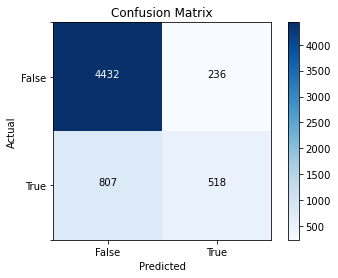

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

### Download the Model Files
To download the Model and all associated files use the code below. 

For more information around the Run class see: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run

In [25]:
#best_run.download_files(prefix='outputs', append_prefix=True)

In [2]:
#best_run.get_file_names()

Download the scoring and environment file used to create the endpoint later.

In [19]:
script_file_name = 'inference/score.py'
conda_env_file_name = 'inference/env.yml'
model_file_name = 'inference/' + best_run.properties['model_name']

best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)
best_run.download_file('outputs/conda_env_v_1_0_0.yml', conda_env_file_name)
best_run.download_file('outputs/model.pkl', model_file_name)

In [20]:
!dir inference /b

AutoMLc50723a2133
env.yml
score.py


### Register the best model
Store the preferred model for your team to use

In [17]:
from azureml.core.resource_configuration import ResourceConfiguration
description = "Predict if a customer will Default on their payment for this month"
tags = {'area': 'risk', 'type': 'classification' }

model_name = best_run.properties['model_name']
print(f"Registering Model: {model_name}")

model = remote_run.register_model(model_name = model_name,
                                  description = description)

Registering Model: AutoMLc50723a2133


Model(workspace=Workspace.create(name='paydmlws91', subscription_id='b9f1c816-0637-419c-b0f6-a8392690c7aa', resource_group='paydmlrg91'), name=AutoMLc50723a2133, id=AutoMLc50723a2133:2, version=2, tags={}, properties={})

In [19]:
model.update_tags_properties(add_tags=tags,
                             add_properties= ({"Code" : "https://github.com/riedwaanb/DefaultPayments"}))
model.add_dataset_references([(dataset_name, dataset)])
model

# Deploy
### Deploy the Model as a webservice

In [25]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

myenv = Environment.from_conda_specification(name="myenv", file_path=conda_env_file_name)
inference_config = InferenceConfig(entry_script=script_file_name, environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = tags,
                                               description = description)

aci_service_name = 'default-payment'
print(f"Deploying Web Service : {aci_service_name}")
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)


Deploying Web Service : default-payment
Running................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
